<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/AutoencoderPytorch_Kaggle_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías

In [1]:
import PIL
import cv2
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

## Descarga de Datos

Nos descargamos las imágenes con un ancho de 256 de ancho. Vamos a ir escalando a 64, 128 y 256. Lo haremos con cv2.resize()

### Kaggle

**Descargamos un dataset de kaggle para aumentar el número de imágenes de prueba**

Tiene las siguientes clases:

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR


A nosotros nos intersan las de la clase 0. 







In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diegorudiezgomez","key":"a97ea3f0837ef30e1012d50ea0d74929"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

**Tras relizar algunas configuraciones descargamos el dataset:**

In [7]:
%%time
! kaggle competitions download -c 'aptos2019-blindness-detection'

100% 9.51G/9.51G [01:26<00:00, 179MB/s]
100% 9.51G/9.51G [01:26<00:00, 119MB/s]
CPU times: user 1.14 s, sys: 213 ms, total: 1.36 s
Wall time: 1min 27s


In [8]:
!unzip -qq aptos2019-blindness-detection.zip -d 'datasetKaggle'

In [9]:
datasetKaggle = 'datasetKaggle'

In [10]:
imgTrain = os.listdir(datasetKaggle + '/train_images')

In [11]:
datasetKaggle + '/train_images/' + imgTrain[0]

'datasetKaggle/train_images/2b07790a2422.png'

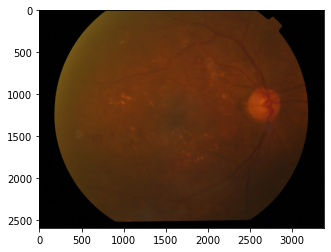

In [12]:
image = cv2.imread(datasetKaggle + '/train_images/' + imgTrain[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [13]:
df_trainKaggle = pd.read_csv(datasetKaggle + '/train.csv')

In [14]:
df_trainKaggle['diagnosis'].value_counts() #1805 imágenes sanas

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [15]:
df_trainKaggle.head(5)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


### Reto

**Ahora las del reto que hemos utilizado siempre.**

In [16]:
# !wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
# !wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
# !wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

In [17]:
# !rm -rvf Training_Set_Pre
# !unzip -qq train.zip #-qq no verbose
# !unzip -qq test.zip
# !unzip -qq val.zip

Descargamos el dataset sin procesar, para aplicar el mismo procesado a los dos datsets

In [18]:
!wget https://www.dropbox.com/s/1isaa8xrrv0x6n4/datasetComprimido.zip?dl=0 --no-verbose -O datasetComp.zip

2022-06-24 09:55:04 URL:https://uc1a638401ca40031922849f693e.dl.dropboxusercontent.com/cd/0/inline2/BnxUsXv9aieMaB85euubP_aMZyyIPEf8DssSvqE2bHhtKBrN9d26xuujh3-VTHI6OzA6oa2nzimPfylKeWkPCEGzKbqD19gFPzSeKDZgJLWv2w1IhVJXR-mPFEhSaqkk-8ZDzRFIsfDIVhdZuQVHdR7JWAQFw7XSinBfmazZRVOY6O6-gnisb_bqAaIgf1kiYAbrXGtvMSPHly37CQImXVJMV5eqiLL1KodPiB6XbvdTh3OKbBcj9bOKaQJzIJi-90ZWa7wfZuI_YQUhWwFPbV3m0-Bz7DX9cxyl0oMvQ3PDDZDxf1S2Krx3iIYo5cMt56-hMyDZe5zME7ykfBcIumhmRCmhUT62QkgWoDNK46MPtShK-NWSdYuzRVgMXCu_XbBkr3U0BAy3tG62omr9YVkrkJCsKUTyj_hN0ayKuI-Ydw/file [144922725/144922725] -> "datasetComp.zip" [1]


In [19]:
!unzip -qq datasetComp.zip

In [20]:
# trainPath = 'Training_Set_Pre/'
# testPath  = 'Test_Set_Pre/'
# valPath  =  'Evaluation_Set_Pre/'

In [21]:
trainPath = 'Training_Set_C/'
testPath  = 'Test_Set_C/'
valPath  =  'Evaluation_Set_C/'

## Preparación de Datos

In [22]:
IMG_SIZE = 64

### Funciones de procesado

In [23]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted(image,4, cv2.GaussianBlur(image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

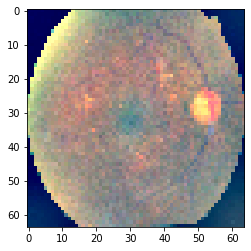

In [24]:
img = load_ben_color(datasetKaggle + '/train_images/' + imgTrain[0], 10)
plt.imshow(img)

### Datos Kaggle

In [25]:
import shutil

def getNpArrayKaggle(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['id_code'], df['diagnosis']):
    # image = load_ben_color(pathO + '/' + str(id) + '.png', sigmaX=30)
    if(int(enf)==0):
      image = load_ben_color(pathO + '/' + str(id) + '.png', sigmaX=30)
      normal.append(np.asarray(image))
    # else:
    #   enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [26]:
normalKaggle, enfermedadKaggle = getNpArrayKaggle(df_trainKaggle, datasetKaggle + '/train_images')

In [27]:
normalKaggle.shape

(1805, 64, 64, 3)

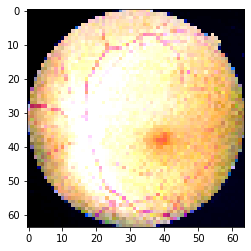

In [28]:
plt.imshow(normalKaggle[0])

### Datos Reto (el mismo de siempre)


In [29]:
import shutil

def getNpArray(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    image = load_ben_color(pathO + '/' + str(id) + '.png', sigmaX=30)
    if(int(enf)==0):
      normal.append(np.asarray(image))
    else:
      enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [30]:
df_train = pd.read_csv(trainPath + '/train.csv')
df_test = pd.read_csv(testPath + '/test.csv')
df_val = pd.read_csv(valPath + '/val.csv')

In [31]:
normalTrain, enfermedadTrain = getNpArray(df_train, trainPath + 'Training/')
normalTest, enfermedadTest = getNpArray(df_test, testPath + 'Test/')
normalVal, enfermedadVal = getNpArray(df_val, valPath + 'Validation/')

In [32]:
normalTrain.shape

(401, 64, 64, 3)

In [33]:
normalTest.shape

(134, 64, 64, 3)

Ya la tenemos reescalada a la medida deseada:

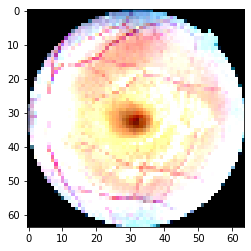

In [34]:
plt.imshow(normalTrain[0])

## Pytorch Autoencoder

https://www.kaggle.com/code/ljlbarbosa/convolution-autoencoder-pytorch/notebook

https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/

In [43]:
from torchvision import datasets, transforms
transform = transforms.ToTensor()

In [44]:
import torch
import torchvision
from torchvision import transforms
from torch import nn

In [253]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [254]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# dataiter = iter(train_loader)
# dataiter.next()

In [255]:
img = normalTrain[0] #[H, W, C]
img.shape

(64, 64, 3)

In [256]:
# imgPytorch = transform(normalTrain[0])#[C, H, W]

In [257]:
x_data = torch.tensor(np.transpose(img, (2,0,1))) #(X, H, W, C)

In [258]:
x_data.shape

torch.Size([3, 64, 64])

In [259]:
def imshow(img):
    # img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

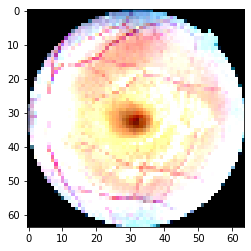

In [260]:
imshow(x_data)

In [261]:
x_data = torch.FloatTensor(normalKaggle) #(X, H, W, C)
x_data.shape

torch.Size([1805, 64, 64, 3])

Transponemos el array, situando los canales en la primera posición

In [262]:
x_data = torch.permute(x_data, (0, 3, 1, 2)) #(X, C, H, W)

In [263]:
x_data.shape

torch.Size([1805, 3, 64, 64])

In [264]:
train_loader = torch.utils.data.DataLoader(x_data, batch_size=128)

In [265]:
# number of epochs to train the model
n_epochs = 20
#Binary Cross Entropy
#https://pytorch.org/docs/stable/nn.html#loss-functions
criterion = nn.BCELoss()

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: -920.913589
Epoch: 2 	Training Loss: -2770.898413
Epoch: 3 	Training Loss: -116705.232585
Epoch: 4 	Training Loss: -1082078.500000
Epoch: 5 	Training Loss: -1691309.376172
Epoch: 6 	Training Loss: -1893249.220703
Epoch: 7 	Training Loss: -1898677.561328
Epoch: 8 	Training Loss: -1899184.581836
Epoch: 9 	Training Loss: -1899370.876628
Epoch: 10 	Training Loss: -1899481.494271
Epoch: 11 	Training Loss: -1899559.436393
Epoch: 12 	Training Loss: -1899614.431836
Epoch: 13 	Training Loss: -1899666.566862
Epoch: 14 	Training Loss: -1899710.746029
Epoch: 15 	Training Loss: -1899749.763932
Epoch: 16 	Training Loss: -1899782.675260
Epoch: 17 	Training Loss: -1899811.055534
Epoch: 18 	Training Loss: -1899833.149023
Epoch: 19 	Training Loss: -1899856.112630
Epoch: 20 	Training Loss: -1899874.284310


### Evaluación

In [266]:
x_test = torch.FloatTensor(enfermedadTest) #(X, H, W, C)
x_test.shape

torch.Size([506, 64, 64, 3])

In [267]:
x_test = torch.permute(x_test, (0, 3, 1, 2)) #(X, C, H, W)

In [268]:
test_loader = torch.utils.data.DataLoader(x_test, batch_size=32, num_workers=0)

In [269]:
dataiter = iter(test_loader)
images = dataiter.next()

In [270]:
output = model(images)
# prep images for display
images = images.numpy()

In [271]:
output = output.view(32, 3, 64, 64)
output = output.detach().numpy()

Reconstructed Images


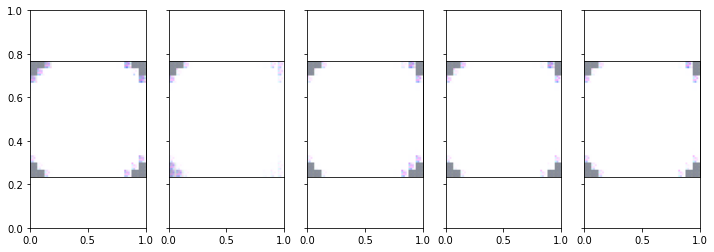

In [272]:
#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show()